# Demand data merging

In this notebook, the three sources of demand data ([total power dispatch](./etl_total_demand.ipynb), [SEIN demand](./etl_sein_demand.ipynb), and [peak demand](./etl_peak_demand.ipynb))  are merged into a single dataset.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score
from pandas.tseries.holiday import Easter
import os
import sagemaker
from sagemaker import get_execution_role

## SEIN peak demand data (collected from meters)

In [3]:
df = pd.read_csv("./peak_demand.csv" )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706944 entries, 0 to 706943
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   N° de Registos/MES   706944 non-null  int64  
 1   Fecha/Hora           706944 non-null  object 
 2   Total (MW)           706944 non-null  float64
 3   Importación (MW)     706944 non-null  float64
 4   Exportación (MW)     706944 non-null  float64
 5   Máxima Demanda (MW)  706944 non-null  float64
 6   filename             706944 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 37.8+ MB


In [4]:
df.head()

,N° de Registos/MES,Fecha/Hora,Total (MW),Importación (MW),Exportación (MW),Máxima Demanda (MW),filename
0,1,27/10/2011 19:00,4787.86208,0.0,0.0,4787.86208,ranking_demand_2011-10.xlsx
1,2,24/10/2011 19:00,4785.41497,0.0,0.0,4785.41497,ranking_demand_2011-10.xlsx
2,3,26/10/2011 19:15,4777.58864,0.0,0.0,4777.58864,ranking_demand_2011-10.xlsx
3,4,26/10/2011 19:30,4777.26644,0.0,0.0,4777.26644,ranking_demand_2011-10.xlsx
4,5,20/10/2011 19:00,4774.50047,0.0,0.0,4774.50047,ranking_demand_2011-10.xlsx


In [5]:
df = df.iloc[:, [1, 5]]
df.columns = ['datetime', 'demand']
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M')
df.sort_values(by='datetime', inplace=True)

In [6]:
df.head()

,datetime,demand
369224,2003-01-01 00:15:00,2358.98170
369374,2003-01-01 00:30:00,2317.31997
369466,2003-01-01 00:45:00,2287.14719
369547,2003-01-01 01:00:00,2248.64036
369630,2003-01-01 01:15:00,2209.47934


Resample demand data to 30-minute periods

In [7]:
df_resampled = df.set_index('datetime').resample(
    '30min', label='right', closed='right')['demand'].max().reset_index()

In [8]:
df = pd.merge(df_resampled, df, how='left', on='datetime', suffixes=('', '_y'))
df = df.drop('demand_y', axis=1)

In [9]:
df.head()

,datetime,demand
0,2003-01-01 00:30:00,2358.98170
1,2003-01-01 01:00:00,2287.14719
2,2003-01-01 01:30:00,2209.47934
3,2003-01-01 02:00:00,2125.32866
4,2003-01-01 02:30:00,2000.68435


In [10]:
df_peak = df.copy()

## SEIN power demand data (from SCADA systems)

In [11]:
df = pd.read_csv("./sein_demand.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127056 entries, 0 to 127055
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   datetime               127056 non-null  object 
 1   TOTAL GENERACIÓN COES  126912 non-null  float64
 2   IMPORTACIÓN  ECUADOR   124657 non-null  float64
 3   TOTAL SEIN             126912 non-null  float64
 4   TOTAL
NO COES          126912 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.8+ MB


In [12]:
df.head()

,datetime,TOTAL GENERACIÓN COES,IMPORTACIÓN ECUADOR,TOTAL SEIN,TOTAL\nNO COES
0,2016-01-01 00:30:00,5028.33192,41.77,4986.56192,22.626
1,2016-01-01 01:00:00,4948.64387,41.23,4907.41387,23.637
2,2016-01-01 01:30:00,4817.33694,38.79,4778.54694,23.007
3,2016-01-01 02:00:00,4702.32782,40.13,4662.19782,22.829
4,2016-01-01 02:30:00,4562.66431,39.50,4523.16431,22.840


In [13]:
df.columns = ['datetime', 'coes_demand', 'import_exports', 'sein_demand', 'non_coes_demand']
df['datetime'] = pd.to_datetime(df['datetime'])
df['import_exports'] = (df['coes_demand'] - df['sein_demand'])
df.sort_values(by='datetime', inplace=True)

In [14]:
df.head()

,datetime,coes_demand,import_exports,sein_demand,non_coes_demand
0,2016-01-01 00:30:00,5028.33192,41.77,4986.56192,22.626
1,2016-01-01 01:00:00,4948.64387,41.23,4907.41387,23.637
2,2016-01-01 01:30:00,4817.33694,38.79,4778.54694,23.007
3,2016-01-01 02:00:00,4702.32782,40.13,4662.19782,22.829
4,2016-01-01 02:30:00,4562.66431,39.50,4523.16431,22.840


In [15]:
df_sein = df.copy()

## Total power dispatch of COES and non-COES generators (total demand)

In [16]:
df = pd.read_csv("./total_demand.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350592 entries, 0 to 350591
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FECHA          350592 non-null  object 
 1   EJECUTADO      350592 non-null  float64
 2   PROG. DIARIA   349728 non-null  float64
 3   PROG. SEMANAL  350592 non-null  float64
dtypes: float64(3), object(1)
memory usage: 10.7+ MB


In [17]:
df.tail()

,FECHA,EJECUTADO,PROG. DIARIA,PROG. SEMANAL
350587,28/02/2023 22:00,7275.16939,7317.62767,7443.17706
350588,28/02/2023 22:30,7246.85625,7287.74214,7335.39421
350589,28/02/2023 23:00,7012.36879,7122.78297,7289.98850
350590,28/02/2023 23:30,6864.95446,6903.65765,6844.23093
350591,01/03/2023 00:00,6700.18698,6733.97599,6835.07893


In [18]:
df.columns = ['datetime', 'total_demand', 'total_demand_daily_plan', 'total_demand_weekly_plan']
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M')
df.sort_values(by='datetime', inplace=True)

In [19]:
df.tail()

,datetime,total_demand,total_demand_daily_plan,total_demand_weekly_plan
350587,2023-02-28 22:00:00,7275.16939,7317.62767,7443.17706
350588,2023-02-28 22:30:00,7246.85625,7287.74214,7335.39421
350589,2023-02-28 23:00:00,7012.36879,7122.78297,7289.98850
350590,2023-02-28 23:30:00,6864.95446,6903.65765,6844.23093
350591,2023-03-01 00:00:00,6700.18698,6733.97599,6835.07893


In [20]:
df_total = df.copy()

## Merge demand data

In [21]:
df = pd.merge(df_peak, df_sein, how='left', on='datetime')
df = pd.merge(df, df_total, how='left', on='datetime')
df

,datetime,demand,coes_demand,import_exports,sein_demand,non_coes_demand,total_demand,total_demand_daily_plan,total_demand_weekly_plan
0,2003-01-01 00:30:00,2358.98170,NaN,NaN,NaN,NaN,2306.76635,2304.71554,2292.96587
1,2003-01-01 01:00:00,2287.14719,NaN,NaN,NaN,NaN,2237.36810,2208.29031,2225.53541
2,2003-01-01 01:30:00,2209.47934,NaN,NaN,NaN,NaN,2150.86425,2125.24247,2147.93319
3,2003-01-01 02:00:00,2125.32866,NaN,NaN,NaN,NaN,2063.83669,2090.81638,2092.68125
4,2003-01-01 02:30:00,2000.68435,NaN,NaN,NaN,NaN,1990.51493,2035.67195,2015.89887
...,...,...,...,...,...,...,...,...,...
353467,2023-02-28 22:00:00,7213.33052,7152.17681,0.0,7152.17681,122.99258,7275.16939,7317.62767,7443.17706
353468,2023-02-28 22:30:00,7221.76318,7148.14381,0.0,7148.14381,98.71244,7246.85625,7287.74214,7335.39421
353469,2023-02-28 23:00:00,7116.23375,6915.98981,0.0,6915.98981,96.37898,7012.36879,7122.78297,7289.98850
353470,2023-02-28 23:30:00,6881.04613,6768.54381,0.0,6768.54381,96.41065,6864.95446,6903.65765,6844.23093


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353472 entries, 0 to 353471
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   datetime                  353472 non-null  datetime64[ns]
 1   demand                    353472 non-null  float64       
 2   coes_demand               125424 non-null  float64       
 3   import_exports            125424 non-null  float64       
 4   sein_demand               125424 non-null  float64       
 5   non_coes_demand           125424 non-null  float64       
 6   total_demand              350592 non-null  float64       
 7   total_demand_daily_plan   349728 non-null  float64       
 8   total_demand_weekly_plan  350592 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 27.0 MB


## Add features for working days and on-peak hours 

In [23]:
# Holidays
holidays = ["1-1", "5-1", "6-29", "7-28", "7-29",
            "8-30", "10-8", "11-1", "12-8", "12-25"]

new_holidays = ['2022-08-06', '2022-12-09', '2023-08-06', '2023-12-09']

start_date = df['datetime'].min().date()
end_date = df['datetime'].max().date()

easter_holidays = pd.date_range(start=start_date, end=end_date, freq=Easter())
thursdays = pd.Series(easter_holidays - pd.Timedelta(days=3))
fridays = pd.Series(easter_holidays - pd.Timedelta(days=2))
thu_fri_list = pd.concat([thursdays, fridays]).tolist()


def is_holiday(row):
    is_holiday = False
    month = row['datetime'].month
    day = row['datetime'].day
    day_of_week = row['datetime'].dayofweek
    row_date = f"{month}-{day}"
    row_datetime = pd.to_datetime(row['datetime'])

    if row_date in holidays:
        is_holiday = True

    for holiday in new_holidays:
        if str(row_datetime.date()) == holiday:
            is_holiday = True

    for day in thu_fri_list:
        if row_datetime.date() == day.date():
            is_holiday = True

    return is_holiday


df['holiday'] = df.apply(is_holiday, axis=1)

In [24]:
#  working days
df['workday'] = ((df['datetime'].dt.dayofweek != 5) &
                 (df['datetime'].dt.dayofweek != 6) &
                 (df['holiday'] == False))

In [25]:
#  on-peak hours
on_peak_start_time = pd.to_datetime('17:00:00').time()
on_peak_end_time = pd.to_datetime('23:00:00').time()

df['on_peak'] = ((df['holiday'] == False) &
                 (df['datetime'].dt.dayofweek != 6) &
                 ((df['datetime'].dt.time > on_peak_start_time) &
                  (df['datetime'].dt.time <= on_peak_end_time)))

In [26]:
df.head()

,datetime,demand,coes_demand,import_exports,sein_demand,non_coes_demand,total_demand,total_demand_daily_plan,total_demand_weekly_plan,holiday,workday,on_peak
0,2003-01-01 00:30:00,2358.98170,NaN,NaN,NaN,NaN,2306.76635,2304.71554,2292.96587,True,False,False
1,2003-01-01 01:00:00,2287.14719,NaN,NaN,NaN,NaN,2237.36810,2208.29031,2225.53541,True,False,False
2,2003-01-01 01:30:00,2209.47934,NaN,NaN,NaN,NaN,2150.86425,2125.24247,2147.93319,True,False,False
3,2003-01-01 02:00:00,2125.32866,NaN,NaN,NaN,NaN,2063.83669,2090.81638,2092.68125,True,False,False
4,2003-01-01 02:30:00,2000.68435,NaN,NaN,NaN,NaN,1990.51493,2035.67195,2015.89887,True,False,False


## Explore demand data

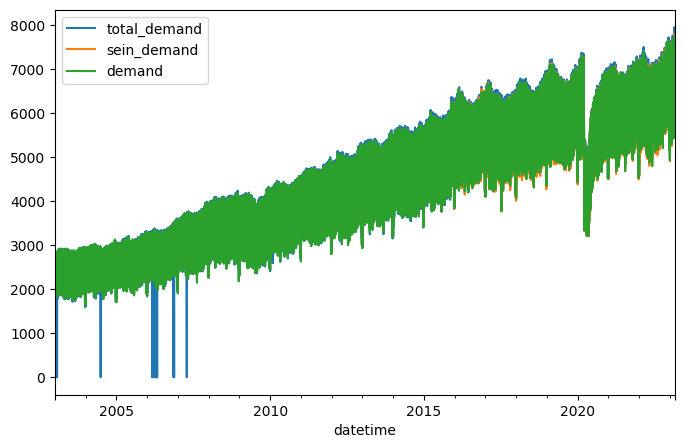

In [27]:
df.plot(x='datetime',
        y=['total_demand', 'sein_demand', 'demand'], figsize=(8, 5))
plt.show()

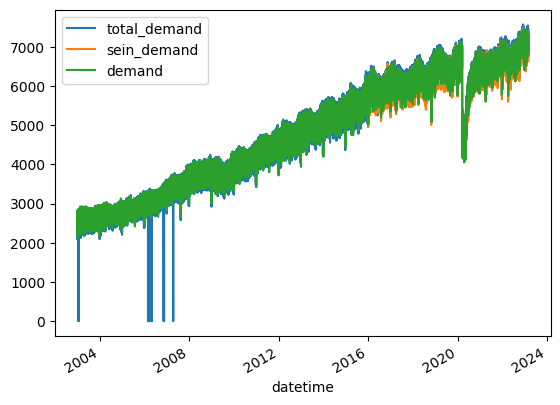

In [28]:
df[df['on_peak']].plot(
    x='datetime', y=['total_demand',  'sein_demand', 'demand']
)
plt.show()

## Evaluate RMSE between SEIN demand from meters and SCADA systems

In [29]:
# rmse
mask = ~np.isnan(df['sein_demand'])
peak_demand = df['demand'][mask]
sein_demand = df['sein_demand'][mask]
rmse = mean_squared_error(peak_demand, sein_demand, squared=False)
print("RMSE:", rmse)

RMSE: 70.1592695127992


In [30]:
# accuracy of peak demand days and sein demand days
df_peak = df[(df['on_peak']) & (df['sein_demand'] > 0)]
idx_demand = df_peak.groupby(
    [df['datetime'].dt.year, df['datetime'].dt.month])['demand'].idxmax()
idx_sein = df_peak.groupby(
    [df['datetime'].dt.year, df['datetime'].dt.month])['sein_demand'].idxmax()

peak_demand_days = df_peak.loc[idx_demand]['datetime'].dt.day
sein_demand_days = df_peak.loc[idx_sein]['datetime'].dt.day

print("Correct days:",
      accuracy_score(peak_demand_days, sein_demand_days, normalize=False))
print("Accuracy:",
      accuracy_score(peak_demand_days, sein_demand_days, normalize=True))

Correct days: 60
Accuracy: 0.6976744186046512


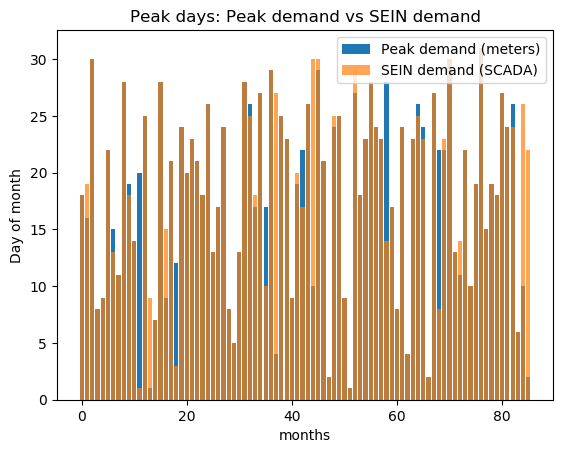

In [34]:
plt.bar(range(len(peak_demand_days)),
        peak_demand_days, label='Peak demand (meters)')
plt.bar(range(len(sein_demand_days)),
        sein_demand_days, alpha=0.7, label='SEIN demand (SCADA)')
plt.xlabel('months')
plt.ylabel('Day of month')
plt.title('Peak days: Peak demand vs SEIN demand')
plt.legend()
plt.show()

## Save merged dataset as csv

In [35]:
df.to_csv('./df_demand.csv', index=False)

## Load data into S3

In [ ]:
os.environ['PROJECT_BUCKET'] = ""

In [41]:
session = sagemaker.Session()
bucket = os.getenv("PROJECT_BUCKET")
region = session.boto_region_name
role = get_execution_role()

print("AWS Region: {}".format(region))

AWS Region: us-east-1


In [ ]:
!aws s3 cp ./df_demand.csv s3://{bucket}/data/